# Batch run on SPARC

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import seaborn as sns
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import GPy
import dipy.reconst.dti as dti
from diGP.preprocessing_pipelines import get_SPARC_train_and_test
from diGP.dataManipulations import DataHandler
from diGP.model import GaussianProcessModel, get_default_kernel, get_default_independent_kernel
from diGP.evaluation import get_SPARC_metrics

%matplotlib inline

In [3]:
with open('../config.json', 'r') as json_file:
    conf = json.load(json_file)
data_paths = conf['SPARC']['data_paths']
q_test_path = conf['SPARC']['q_test_path']

In [4]:
source = 'gradient_20'
gtab, data, voxelSize = get_SPARC_train_and_test(data_paths[source], data_paths['goldstandard'], q_test_path)

Loaded existing non-negative data.
Loaded existing non-negative data.


In [5]:
from dipy.core.gradients import gradient_table
bval_threshold = 1500
cutoff = gtab['train'].bvals < bval_threshold
gtab['cutoff'] = gradient_table(bvals=gtab['train'].bvals[cutoff],
                                bvecs=gtab['train'].bvecs[cutoff])
S0_tenmodel = dti.TensorModel(gtab['cutoff'], return_S0_hat=True)
S0_tenfit = S0_tenmodel.fit(data['train'][:, :, None, cutoff])

b0_DTI = np.squeeze(S0_tenfit.S0_hat)
b0 = np.squeeze(data['train'][:, :, gtab['train'].b0s_mask])

data['train'] /= b0_DTI[:, :, None]
data['test'] /= b0_DTI[:, :, None]

Specify the various configurations to run.

In [6]:
mean = ['', 'DTI', 'MAPL']
n_max = [0, 2, 4, 6, 8]

# Make predictions and save results

Fit regular DTI model

In [7]:
tenmodel = dti.TensorModel(gtab['train'])
tenfit = tenmodel.fit(data['train'])

fitted = {'DTI': tenfit.predict(gtab['train'])}
pred = {'DTI': tenfit.predict(gtab['test'])}

Load precomputed MAPL results

In [8]:
fitted['MAPL'] = np.load(os.path.join(data_paths[source], 'map_mri_train.npy'))
pred['MAPL'] = np.load(os.path.join(data_paths[source], 'map_mri_test.npy'))

fitted['MAPL'] = np.load(os.path.join(data_paths[source], 'map_mri_train_iso.npy'))
pred['MAPL'] = np.load(os.path.join(data_paths[source], 'map_mri_test_iso.npy'))

Specify dummy model for the case with no mean function.

In [9]:
fitted[''] = np.zeros_like(fitted['DTI'])
pred[''] = np.zeros_like(pred['DTI'])

In [10]:
# Vary the maximum order of the Legendre polynomials, without spatial correlations
for base_model in mean:    
    for n in n_max:
        if base_model == '':
            name = 'GP_n{}_indep'.format(n)
        else:
            name = "{} + GP_n{}_indep".format(base_model, n)
        
        print('\nRunning {}'.format(name))
        kernel = get_default_independent_kernel(spatial_dims=2, n_max=n)
        gp_model = GaussianProcessModel(gtab['train'], spatial_dims=2, kernel=kernel)
        gp_fit = gp_model.fit(data['train'], mean=fitted[base_model], voxel_size=voxelSize[0:2])

        pred[name] = gp_fit.predict(gtab['test'], mean=pred[base_model],
                                    spatial_shape=data['test'].shape[0:2], voxel_size=voxelSize[0:2])
    


Running GP_n0_indep

Running GP_n2_indep

Running GP_n4_indep

Running GP_n6_indep

Running GP_n8_indep

Running DTI + GP_n0_indep

Running DTI + GP_n2_indep

Running DTI + GP_n4_indep

Running DTI + GP_n6_indep

Running DTI + GP_n8_indep

Running MAPL + GP_n0_indep

Running MAPL + GP_n2_indep

Running MAPL + GP_n4_indep

Running MAPL + GP_n6_indep

Running MAPL + GP_n8_indep


In [11]:
# Vary the maximum order of the Legendre polynomials, with spatial correlations
for base_model in mean:    
    for n in n_max:
        if base_model == '':
            name = 'GP_n{}'.format(n)
        else:
            name = "{} + GP_n{}".format(base_model, n)
        
        print('\nRunning {}'.format(name))
        kernel = get_default_kernel(spatial_dims=2, n_max=n)
        gp_model = GaussianProcessModel(gtab['train'], spatial_dims=2, kernel=kernel)
        try:
            gp_fit = gp_model.fit(data['train'], mean=fitted[base_model], voxel_size=voxelSize[0:2])
        except:
            continue
        
        pred[name] = gp_fit.predict(gtab['test'], mean=pred[base_model],
                                        spatial_shape=data['test'].shape[0:2], voxel_size=voxelSize[0:2])



Running GP_n0

Running GP_n2

Running GP_n4

Running GP_n6

Running GP_n8

Running DTI + GP_n0

Running DTI + GP_n2

Running DTI + GP_n4

Running DTI + GP_n6

Running DTI + GP_n8

Running MAPL + GP_n0

Running MAPL + GP_n2

Running MAPL + GP_n4

Running MAPL + GP_n6

Running MAPL + GP_n8


In [12]:
with open(os.path.join(data_paths[source], 'batch_run_prediction_results.p'), 'wb') as fp:
    pickle.dump(pred, fp)

# Load and plot

In [13]:
with open(os.path.join(data_paths[source], 'batch_run_prediction_results.p'), 'rb') as fp:
    pred = pickle.load(fp)

In [14]:
NMSE_low = {}
NMSE_high = {}
for key in sorted(pred.keys()):
    this_NMSE_low, this_NMSE_high, _ = get_SPARC_metrics(gtab['test'], data['test'], pred[key], verbose=False)
    NMSE_low[key] = this_NMSE_low
    NMSE_high[key] = this_NMSE_high

In [15]:
GP_low = np.array([NMSE_low['GP_n0'], NMSE_low['GP_n2'], NMSE_low['GP_n4'], NMSE_low['GP_n6'], NMSE_low['GP_n8']])
GP_high = np.array([NMSE_high['GP_n0'], NMSE_high['GP_n2'], NMSE_high['GP_n4'], NMSE_high['GP_n6'], NMSE_high['GP_n8']])

GP_indep_low = np.array([NMSE_low['GP_n0_indep'], NMSE_low['GP_n2_indep'], NMSE_low['GP_n4_indep'],
                         NMSE_low['GP_n6_indep'], NMSE_low['GP_n8_indep']])
GP_indep_high = np.array([NMSE_high['GP_n0_indep'], NMSE_high['GP_n2_indep'], NMSE_high['GP_n4_indep'],
                         NMSE_high['GP_n6_indep'], NMSE_high['GP_n8_indep']])

DTI_GP_low = np.array([NMSE_low['DTI + GP_n0'], NMSE_low['DTI + GP_n2'], NMSE_low['DTI + GP_n4'],
                       NMSE_low['DTI + GP_n6'], NMSE_low['DTI + GP_n8']])
DTI_GP_high = np.array([NMSE_high['DTI + GP_n0'], NMSE_high['DTI + GP_n2'], NMSE_high['DTI + GP_n4'],
                        NMSE_high['DTI + GP_n6'], NMSE_high['DTI + GP_n8']])

DTI_GP_indep_low = np.array([NMSE_low['DTI + GP_n0_indep'], NMSE_low['DTI + GP_n2_indep'], NMSE_low['DTI + GP_n4_indep'],
                         NMSE_low['DTI + GP_n6_indep'], NMSE_low['DTI + GP_n8_indep']])
DTI_GP_indep_high = np.array([NMSE_high['DTI + GP_n0_indep'], NMSE_high['DTI + GP_n2_indep'], NMSE_high['DTI + GP_n4_indep'],
                         NMSE_high['DTI + GP_n6_indep'], NMSE_high['DTI + GP_n8_indep']])

MAPL_GP_low = np.array([NMSE_low['MAPL + GP_n0'], NMSE_low['MAPL + GP_n2'], NMSE_low['MAPL + GP_n4'],
                        NMSE_low['MAPL + GP_n6'], NMSE_low['MAPL + GP_n8']])
MAPL_GP_high = np.array([NMSE_high['MAPL + GP_n0'], NMSE_high['MAPL + GP_n2'], NMSE_high['MAPL + GP_n4'],
                        NMSE_high['MAPL + GP_n6'], NMSE_high['MAPL + GP_n8']])

MAPL_GP_indep_low = np.array([NMSE_low['MAPL + GP_n0_indep'], NMSE_low['MAPL + GP_n2_indep'], NMSE_low['MAPL + GP_n4_indep'],
                        NMSE_low['MAPL + GP_n6_indep'], NMSE_low['MAPL + GP_n8_indep']])
MAPL_GP_indep_high = np.array([NMSE_high['MAPL + GP_n0_indep'], NMSE_high['MAPL + GP_n2_indep'], NMSE_high['MAPL + GP_n4_indep'],
                        NMSE_high['MAPL + GP_n6_indep'], NMSE_high['MAPL + GP_n8_indep']])

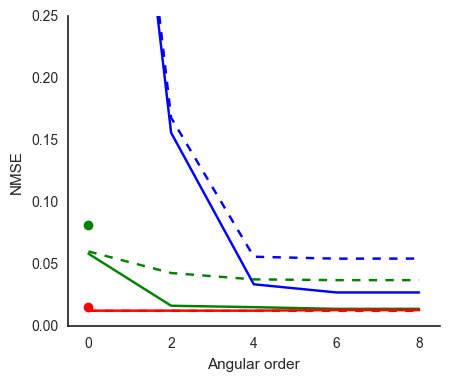

In [16]:
sns.set_style('white')

fig = plt.figure()
ax = plt.subplot(111)

plt.plot(n_max, GP_low, 'b-', n_max, GP_indep_low, 'b--',
           0, NMSE_low['DTI'], 'go', n_max, DTI_GP_low, 'g-', n_max, DTI_GP_indep_low, 'g--',
           0, NMSE_low['MAPL'], 'ro', n_max, MAPL_GP_low, 'r-', n_max, MAPL_GP_indep_low, 'r--')


plt.axis([-0.5, 8.5, 0, 0.25])
plt.xticks(n_max)
plt.xlabel('Angular order')
plt.ylabel('NMSE')

# Shrink current axis by 20% to match size of the next figure
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('NMSE_low.png', transparent=True)

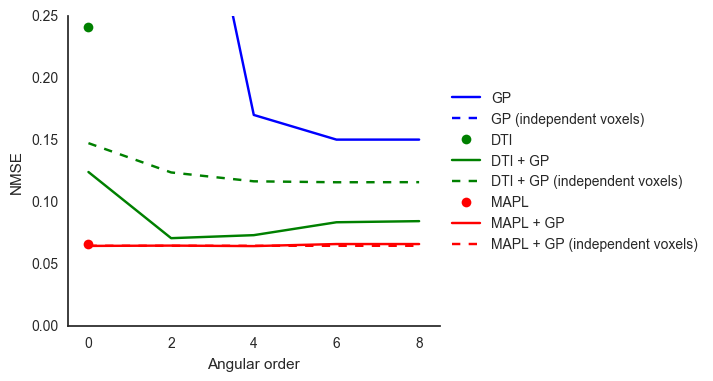

In [17]:
fig = plt.figure()
ax = plt.subplot(111)

plt.plot(n_max, GP_high, 'b-', label='GP')
plt.plot(n_max, GP_indep_high, 'b--', label='GP (independent voxels)')
plt.plot(0, NMSE_high['DTI'], 'go', label='DTI')
plt.plot(n_max, DTI_GP_high, 'g-', label='DTI + GP')
plt.plot(n_max, DTI_GP_indep_high, 'g--', label='DTI + GP (independent voxels)')
plt.plot(0, NMSE_high['MAPL'], 'ro', label='MAPL')
plt.plot(n_max, MAPL_GP_high, 'r-', label='MAPL + GP')
plt.plot(n_max, MAPL_GP_indep_high, 'r--', label='MAPL + GP (independent voxels)')
         
plt.axis([-0.5, 8.5, 0, 0.25])
plt.xticks(n_max)
plt.xlabel('Angular order')
plt.ylabel('NMSE')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('NMSE_high.png', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')

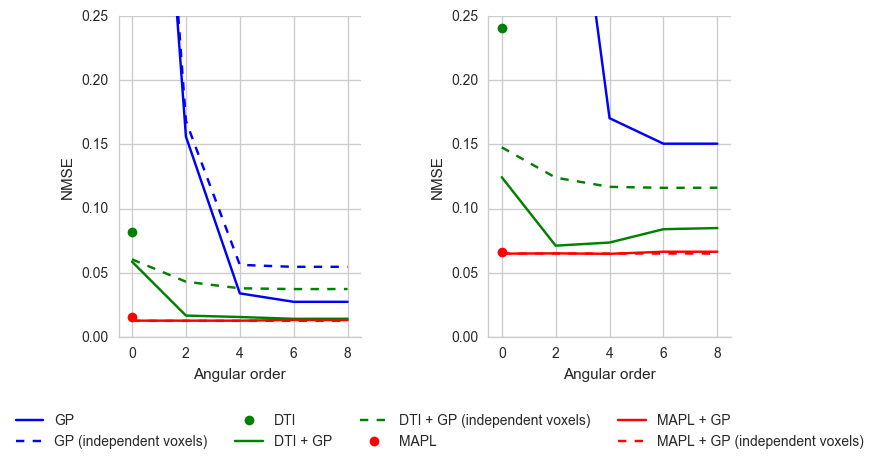

In [18]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(7, 4))

ax[0].plot(n_max, GP_low, 'b-', n_max, GP_indep_low, 'b--',
           0, NMSE_low['DTI'], 'go', n_max, DTI_GP_low, 'g-', n_max, DTI_GP_indep_low, 'g--',
           0, NMSE_low['MAPL'], 'ro', n_max, MAPL_GP_low, 'r-', n_max, MAPL_GP_indep_low, 'r--')

ax[1].plot(n_max, GP_high, 'b-', label='GP')
ax[1].plot(n_max, GP_indep_high, 'b--', label='GP (independent voxels)')
ax[1].plot(0, NMSE_high['DTI'], 'go', label='DTI')
ax[1].plot(n_max, DTI_GP_high, 'g-', label='DTI + GP')
ax[1].plot(n_max, DTI_GP_indep_high, 'g--', label='DTI + GP (independent voxels)')
ax[1].plot(0, NMSE_high['MAPL'], 'ro', label='MAPL')
ax[1].plot(n_max, MAPL_GP_high, 'r-', label='MAPL + GP')
ax[1].plot(n_max, MAPL_GP_indep_high, 'r--', label='MAPL + GP (independent voxels)')

for a in ax:
    a.axis([-0.5, 8.5, 0, 0.25])
    a.set_xticks(n_max)
    a.set_xlabel('Angular order')
    a.set_ylabel('NMSE')

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    box = a.get_position()
    a.set_position([box.x0, box.y0, box.width, box.height])

lgd = ax[1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.2), ncol=4)
fig.tight_layout(w_pad=5)
plt.savefig('NMSE.png', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')